In [2]:
import sys,os,pickle,copy
sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
import numpy as np
import numpy
import pandas as pd
import scipy
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload
import seaborn as sns

import preprocess as prep

from sklearn.decomposition import NMF

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
import matplotlib.pyplot as plt
%matplotlib inline

import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import pynapple as nap

In [3]:
import jaxopt

In [4]:
sess_name="e15_13f1_220117"#'e13_26m1_210913'#
data_dir_full = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117"#'/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913' #
py_data_dir = os.path.join(data_dir_full,"py_data")
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr_df=  fr_['df']
fr_pyr = fr_['df']['pyr']
fr_int = fr_['df']['int']
fr_map_trial = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']
fr_map_avg=pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map']
cell_cols = fr_['cell_cols']
cell_cols_pyr=np.array(cell_cols['pyr'],dtype=object)
cell_cols_int =np.array(cell_cols['int'],dtype=object)


In [5]:
data_dir_full = data_dir_full
to_return=prep.load_stuff(data_dir_full)

cell_metrics=to_return['cell_metrics']
behavior=to_return['behavior']
ripple_events=to_return['ripple_events']
mergepoints=to_return['mergepoints']
cell_type_mask=to_return['cell_type_mask']
pyr_uid=to_return['pyr_uid']

trial_ind_d = {ch:np.nonzero(behavior.trials.visitedArm==ch)[0] for ch in [0,1]}
dt = np.diff(behavior.timestamps).mean()

In [6]:
import glob
mono_res=glob.glob(os.path.join(data_dir_full,'*mono_res*'))[0]
mono_res = dpn.loadmat_full(mono_res,'mono_res')

In [7]:
fn = os.path.join(data_dir_full,'py_data','synapses_all_epoch.p')
synapses= pickle.load(open(fn,'rb'))

In [8]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering


# gm

In [20]:
import jax
from jax import jit, vmap, flatten_util
import jaxopt
import gm
import jax.numpy as jnp
import math_functions as mf
import gm_plot as gp
reload(gp)
reload(gm)

<module 'gm' from '/mnt/home/szheng/projects/util_code/gm.py'>

In [252]:
np.nonzero(pyr_uid==98)

(array([56]),)

In [109]:
trial_type= 0
target = fr_map_trial[trial_type] # n_neurons  x n_pos x n_trials
n_neurons, n_pos, n_trials = target.shape
nfields_max = 4
mask = None
regressors = gm.get_regressors({'ntrials':n_trials})
rngkey = jax.random.PRNGKey(1)
rngkey_l = jax.random.split(rngkey,n_neurons)

par_l,par_trans_l=gm.init_population(rngkey_l,regressors,nfields=nfields_max,range_dict={'ws':[20,40],'b':[0,4],'sigmas':[20,40],'mus':[10,90]})

# nfields_mask_l = gm.gen_nfields_mask_l([2]*n_neurons,nfields_max=nfields_max)
reg_pars_l = gm.get_reg_pars_population(n_neurons, {'nfields':2,'ws':0.001,'b':0.0001,'sigmas':1.,'mus':0.01,
                                                    'mus_seperation':0.,'mus_seperation_thresh':10.,'order':1.})


In [12]:
reload(gm)
model_type_kwargs = {'common_mu':False,'common_sigma':True}
init_loss = gm.forward_and_loss(target,regressors,par_trans_l,reg_pars_l,mask,**model_type_kwargs)
%time par_trans_fit,opt_state = gm.fit_population(target, regressors, par_trans_l, reg_pars_l, lr=0.1, niters=4000, mask=None, opt_state=None,common_mu=True,common_sigma=True)
final_loss = gm.forward_and_loss(target,regressors,par_trans_fit,reg_pars_l,mask,common_mu=True,common_sigma=True)
%time par_trans_fit_ft,opt_state = gm.fit_population(target, regressors, par_trans_fit, reg_pars_l, lr=0.05, niters=4000, mask=None, opt_state=opt_state,common_mu=False,common_sigma=False)
final_loss_ft = gm.forward_and_loss(target,regressors,par_trans_fit_ft,reg_pars_l,mask,common_mu=False,common_sigma=False)


CPU times: user 2min 2s, sys: 203 ms, total: 2min 2s
Wall time: 1min 15s
CPU times: user 2min 2s, sys: 243 ms, total: 2min 3s
Wall time: 1min 15s


In [275]:
reload(gp)
reload(gm)

<module 'gm' from '/mnt/home/szheng/projects/util_code/gm.py'>

(<Figure size 576x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'ws'}>,
        <AxesSubplot:title={'center':'mus'}>,
        <AxesSubplot:title={'center':'sigmas'}>,
        <AxesSubplot:title={'center':'b'}>], dtype=object))

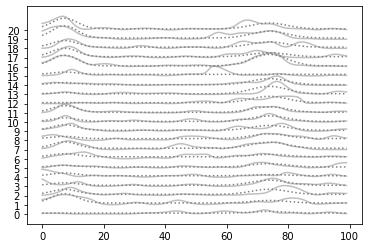

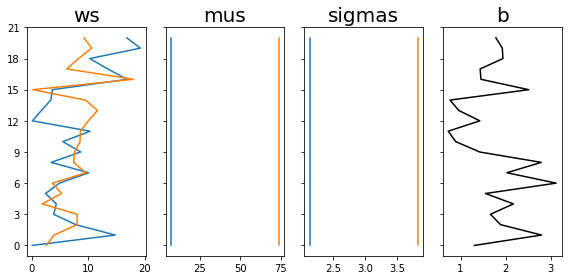

In [13]:
%matplotlib inline
yy=0
target_one = target[yy]
par_trans_fit_one = gm.index_into_pytree(par_trans_fit,yy)
par_fit_one = gm.par_invtransform(par_trans_fit_one,True,True)
nfields_mask_one = reg_pars_l['nfields_mask'][yy]
par_fit_one = gm.mask_fields(par_fit_one,nfields_mask_one)
gp.plot_fit_original(target_one,par_trans_fit_one,nfields_mask_one)
gp.plot_params(par_fit_one)

(<Figure size 576x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'ws'}>,
        <AxesSubplot:title={'center':'mus'}>,
        <AxesSubplot:title={'center':'sigmas'}>,
        <AxesSubplot:title={'center':'b'}>], dtype=object))

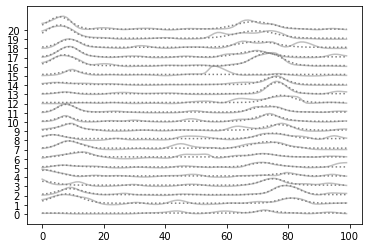

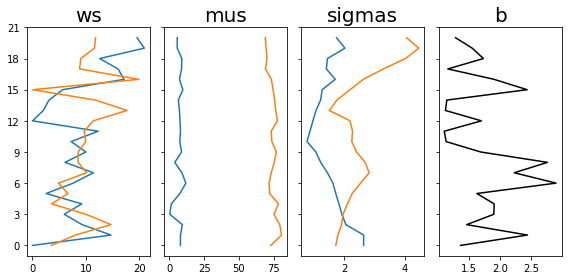

In [15]:
%matplotlib inline
yy=0
target_one = target[yy]
par_trans_fit_one = gm.index_into_pytree(par_trans_fit_ft,yy)
par_fit_one = gm.par_invtransform(par_trans_fit_one,False,False)
nfields_mask_one = reg_pars_l['nfields_mask'][yy]
par_fit_one = gm.mask_fields(par_fit_one,nfields_mask_one)
gp.plot_fit_original(target_one,par_trans_fit_one,nfields_mask_one)
gp.plot_params(par_fit_one)

In [161]:
import jax.numpy as np
import numpy
from jaxopt import LevenbergMarquardt as LM

In [329]:
# try levenberg Marquardt
forward_population = gm.forward_population
forward_one_neuron = gm.forward_one_neuron
par_invtransform = gm.par_invtransform


@jit
def order_prior(g_order,mus,nfields_mask):
    '''
    # enforcing lower index corresponding to field with lower location
    mus: ntrialtypes x nmaxfields
    mask: nmaxfields,
    '''
    diff = np.diff(mus,axis=1,prepend=0.)
    # masked_diff = np.dot(diff,nfields_mask)
#     nonzeroparts = -jax.nn.relu(-diff)
#     nonzeroparts = jax.nn.relu(-diff) # here it's diff instead of the -diff in the original mf
    nonzeroparts = mf.softplus(-diff) # here it's diff instead of the -diff in the original mf
    R_order = g_order * np.dot(nonzeroparts,nfields_mask) / np.sum(nfields_mask) 
    return R_order.flatten()

@jit
def regularization_resid(par_trans,regressors,reg_pars,common_mu=False, common_sigma=False):
    par = par_invtransform(par_trans,common_mu=common_mu, common_sigma=common_sigma)
    R = 0
    nfields_mask = reg_pars['nfields_mask']
    R = []
    # quadratic variaton; [!!!] need to make a masked version, right now perhaps ok
    for k in ['mus','sigmas','ws','b']:
        R_var =  reg_pars[k] * jnp.diff(par[k],axis=0) # different from before, larger reg_pars larger penalty
        R.append(R_var.flatten())
    # field seperation
#     R += reg_pars['mus_seperation'] * quadratic_seperation(par['mus'],reg_pars['mus_seperation_thresh'],nfields_mask)

    # order:
    R_order =order_prior(reg_pars['order'],par['mus'],nfields_mask)
#     R.append(jnp.array([R_order])) # make it an jnp array instead of a number
    R.append(R_order) # make it an jnp array instead of a number
    return R

@jit
def forward_and_resid_one_neuron(par_trans,target,regressors,nfields_mask, common_mu=False, common_sigma=False):
#     par_trans = unflatten_func(par_trans_flattened)
    pred = forward_one_neuron(regressors, par_trans,nfields_mask,common_mu=common_mu,common_sigma=common_sigma)
    resid = target - pred
    
    return resid.flatten()
@jit
def forward_and_resid_one_neuron_with_reg(par_trans_flattened,target,regressors,reg_pars, common_mu=False, common_sigma=False):
    nfields_mask = reg_pars['nfields_mask']
    par_trans = unflatten_func(par_trans_flattened)
    resid = forward_and_resid_one_neuron(par_trans,target,regressors,nfields_mask, common_mu=common_mu, common_sigma=common_sigma)
#     resid_rescaled = resid / resid.shape[0]
    R = regularization_resid(par_trans,regressors,reg_pars,common_mu=common_mu, common_sigma=common_sigma)
    all_resid=jnp.concatenate([resid.flatten(),*R])
    return all_resid
#     return jnp.concatenate(R)

def forward_and_mse_one_neuron(par_trans_flattened,target,regressors,nfields_mask, common_mu=False, common_sigma=False):
    resid =forward_and_resid_one_neuron(par_trans_flattened,target,regressors,nfields_mask, common_mu=common_mu, common_sigma=common_sigma)
    return jnp.sum(resid**2)
    


In [330]:
regressors['ntrials'] = 1
par,par_trans=gm.init(rngkey,regressors,nfields=nfields_max,range_dict={'ws':[20,40],'b':[0,4],'sigmas':[20,40],'mus':[10,90]})

# nfields_mask_l = gm.gen_nfields_mask_l([2]*n_neurons,nfields_max=nfields_max)
reg_pars = gm.get_reg_pars({'nfields':2,'ws':0.001,'b':0.0001,'sigmas':1.,'mus':0.01,
                                                    'mus_seperation':0.,'mus_seperation_thresh':10.,'order':1.})
target = fr_map_trial[trial_type][0][:,[2]]

In [237]:
# par_trans['mus_bar']=jnp.array([[50.,10.,0.,0.]])

In [238]:
# par_trans

{'b_bar': DeviceArray([[-0.5039145]], dtype=float32),
 'b_delta': DeviceArray([[0.]], dtype=float32),
 'ws_bar': DeviceArray([[31.37105 , 26.44912 , 37.786594, 29.433825]], dtype=float32),
 'ws_delta': DeviceArray([[0., 0., 0., 0.]], dtype=float32),
 'sigmas_bar': DeviceArray([[31.37105 , 26.44912 , 37.786594, 29.433825]], dtype=float32),
 'sigmas_delta': DeviceArray([[0., 0., 0., 0.]], dtype=float32),
 'mus_bar': DeviceArray([[50., 10.,  0.,  0.]], dtype=float32),
 'mus_delta': DeviceArray([[0., 0., 0., 0.]], dtype=float32)}

In [343]:

lm = LM(forward_and_resid_one_neuron_with_reg,verbose=False,maxiter=200,stop_criterion='madsen-nielsen',damping_parameter=1e-6)
par_trans_flattened, unflatten_func = flatten_util.ravel_pytree(par_trans)
%time lm_res = lm.run(par_trans_flattened,target,regressors,reg_pars,common_mu=False, common_sigma=False)



CPU times: user 9.11 s, sys: 59.7 ms, total: 9.17 s
Wall time: 9.09 s


In [174]:
def test_resid(par):
    return jax.nn.relu(-jnp.diff(par))

In [344]:
lm_sol = lm_res.params
par_trans_fit = unflatten_func(lm_sol)#unflatten_func(gn_sol)#unflatten_func(gd_sol)
par_fit = gm.par_invtransform(par_trans_fit)

In [345]:
regularization_resid(par_trans_fit,regressors,reg_pars,common_mu=False, common_sigma=False)

[DeviceArray([], dtype=float32),
 DeviceArray([], dtype=float32),
 DeviceArray([], dtype=float32),
 DeviceArray([], dtype=float32),
 DeviceArray([8.3615996e-05], dtype=float32)]

In [346]:
lm_res.state

LevenbergMarquardtState(iter_num=DeviceArray(200, dtype=int32, weak_type=True), damping_factor=DeviceArray(1.0175222e-10, dtype=float32), increase_factor=DeviceArray(2., dtype=float32, weak_type=True), residual=DeviceArray([-2.0420825e+00, -1.7595001e+00, -1.2329328e+00,
             -4.4720745e-01,  6.9320178e-01,  2.3059688e+00,
              4.4311113e+00,  6.8621230e+00,  9.0084190e+00,
              1.0073135e+01,  9.6001797e+00,  7.8620872e+00,
              5.6212921e+00,  3.5840364e+00,  2.0762079e+00,
              1.0453496e+00,  2.4946690e-01, -4.9234509e-01,
             -1.1561912e+00, -1.6063812e+00, -1.7735395e+00,
             -1.7042902e+00, -1.4854990e+00, -1.1713481e+00,
             -7.7076817e-01, -2.9799485e-01,  1.2434077e-01,
              2.2045064e-01, -2.1756721e-01, -9.9166727e-01,
             -1.6837214e+00, -2.1135225e+00, -2.3401608e+00,
             -2.4663253e+00, -2.5601630e+00, -2.6574769e+00,
             -2.7767000e+00, -2.9235303e+00, -3.0832160e+

In [347]:
par_fit

{'b': DeviceArray([[0.]], dtype=float32),
 'b_bar': DeviceArray([[0.]], dtype=float32),
 'ws': DeviceArray([[1.1654755e+05, 4.8029134e-03, 3.7786594e+01, 2.9433825e+01]],            dtype=float32),
 'ws_bar': DeviceArray([[1.1654755e+05, 4.8029134e-03, 3.7786594e+01, 2.9433825e+01]],            dtype=float32),
 'sigmas': DeviceArray([[636.95056 ,  48.562775,  37.786594,  29.433825]], dtype=float32),
 'sigmas_bar': DeviceArray([[636.95056 ,  48.562775,  37.786594,  29.433825]], dtype=float32),
 'mus': DeviceArray([[2955.903  , 2964.599  ,   55.4842 ,   81.14638]], dtype=float32),
 'mus_bar': DeviceArray([[1495.8497 , 1506.1672 ,   55.4842 ,   81.14638]], dtype=float32)}

(<Figure size 576x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'ws'}>,
        <AxesSubplot:title={'center':'mus'}>,
        <AxesSubplot:title={'center':'sigmas'}>,
        <AxesSubplot:title={'center':'b'}>], dtype=object))

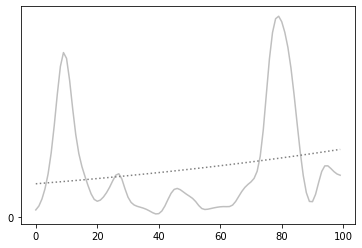

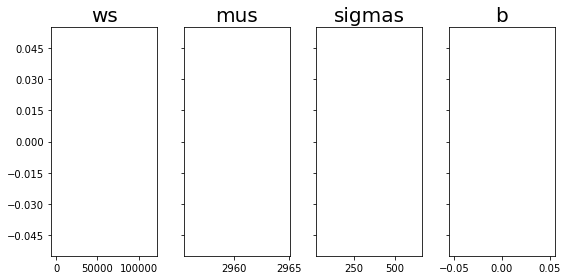

In [348]:
%matplotlib inline
yy=0
target_one = target
par_trans_fit_one = par_trans_fit#gm.index_into_pytree(par_trans_fit_ft,yy)
par_fit_one = par_fit#gm.par_invtransform(par_trans_fit_one,False,False)
nfields_mask_one = reg_pars['nfields_mask']
par_fit_one = gm.mask_fields(par_fit_one,reg_pars['nfields_mask'])
gp.plot_fit_original(target,par_trans_fit,reg_pars['nfields_mask'])
gp.plot_params(par_fit_one)


In [48]:
def test_resid(par):
#     resid=10 - par['a'] * 1. + par['b'] * 2
    resid = 10 - par[0] * 1. + par[1] * 2.
    return resid
    

In [54]:
import jax.flatten_util
leaves,treedef = jax.flatten_util.ravel_pytree(par_init)

In [57]:
treedef(leaves)

{'a': DeviceArray(2., dtype=float32, weak_type=True),
 'b': DeviceArray(3., dtype=float32, weak_type=True)}

In [58]:
lm=LM(test_resid)
par_init = {'a':jnp.array(2.),'b':jnp.array(3.)}
# par_init = jnp.array([2.,3.])
lm.run(leaves).params

DeviceArray([ 4.799998 , -2.5999956], dtype=float32)

# NMF on fitted

In [288]:
par_fit_ft = jax.vmap(gm.par_invtransform,in_axes=(0,None,None))(par_trans_fit_ft,False,False)

In [326]:
nneurons,ntrials,nfields = par_fit_ft['ws'].shape
ws_population = par_fit_ft['ws'].swapaxes(1,2).reshape(-1,ntrials)
mask_population = reg_pars_l['nfields_mask'].flatten().astype(bool)
ws_population = ws_population[mask_population]

In [331]:
import nmf_analysis as na
X = ws_population
X_normed,neuron_field_mask,non_na_original_ind = na.normalize(X)
k = 3
W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted = na.nmf_and_sort(X_normed, k, model=None)

import nmf_plot as nmfp
nmfp.plot_wh(W_sorted,H_sorted)


In [348]:
mus_delta = par_fit_ft['mus'] - par_fit_ft['mus_bar']

In [350]:
nneurons,ntrials,nfields = par_fit_ft['ws'].shape
mus_delta_population = mus_delta.swapaxes(1,2).reshape(-1,ntrials)
mask_population = reg_pars_l['nfields_mask'].flatten().astype(bool)
mus_delta_population = mus_delta_population[mask_population]

In [369]:
n_clust = 10
clust = KMeans(n_clust)
X = mus_delta_population
EPS = 1e-8
# X_normed = X / (X.std(axis=1,keepdims=True) + EPS)
X_normed = X
labels = clust.fit_predict(X_normed)

In [370]:
mus_delta_df = pd.DataFrame(mus_delta_population)
mus_delta_df['clust'] = labels

<AxesSubplot:>

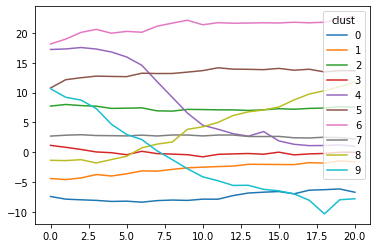

In [371]:
mus_delta_df.groupby('clust').mean().T.plot()

In [372]:
mus_delta_df.groupby('clust').count()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
clust,,,,,,,,,,,,,,,,,,,,,
0,52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
1,107,107,107,107,107,107,107,107,107,107,...,107,107,107,107,107,107,107,107,107,107
2,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
3,177,177,177,177,177,177,177,177,177,177,...,177,177,177,177,177,177,177,177,177,177
4,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
5,37,37,37,37,37,37,37,37,37,37,...,37,37,37,37,37,37,37,37,37,37
6,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
7,147,147,147,147,147,147,147,147,147,147,...,147,147,147,147,147,147,147,147,147,147
8,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44


<AxesSubplot:>

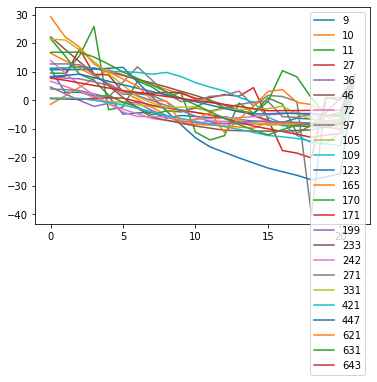

In [375]:
mus_delta_df.query('clust==9').T.plot()

In [378]:
mus_delta_df.query('clust==9').index[ii]

Int64Index([  9,  10,  11,  27,  36,  46,  72,  97, 105, 109, 123, 165, 170,
            171, 199, 233, 242, 271, 331, 421, 447, 621, 631, 643],
           dtype='int64')

(<Figure size 576x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'ws'}>,
        <AxesSubplot:title={'center':'mus'}>,
        <AxesSubplot:title={'center':'sigmas'}>,
        <AxesSubplot:title={'center':'b'}>], dtype=object))

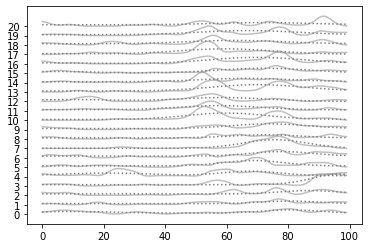

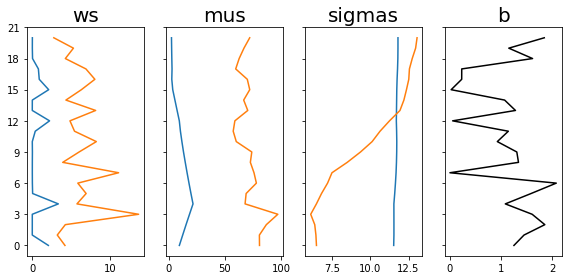

In [380]:
%matplotlib inline
ii=1
yy=mus_delta_df.query('clust==9').index[ii] // 2
target_one = target[yy]
par_trans_fit_one = gm.index_into_pytree(par_trans_fit_ft,yy)
par_fit_one = gm.par_invtransform(par_trans_fit_one,False,False)
nfields_mask_one = reg_pars_l['nfields_mask'][yy]
par_fit_one = gm.mask_fields(par_fit_one,nfields_mask_one)
gp.plot_fit_original(target_one,par_trans_fit_one,nfields_mask_one)
gp.plot_params(par_fit_one)

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(


(<Figure size 594x959.04 with 4 Axes>,
 {'W': <AxesSubplot:label='W', xlabel='component', ylabel='neuron'>,
  'H': <AxesSubplot:label='H', ylabel='component'>})

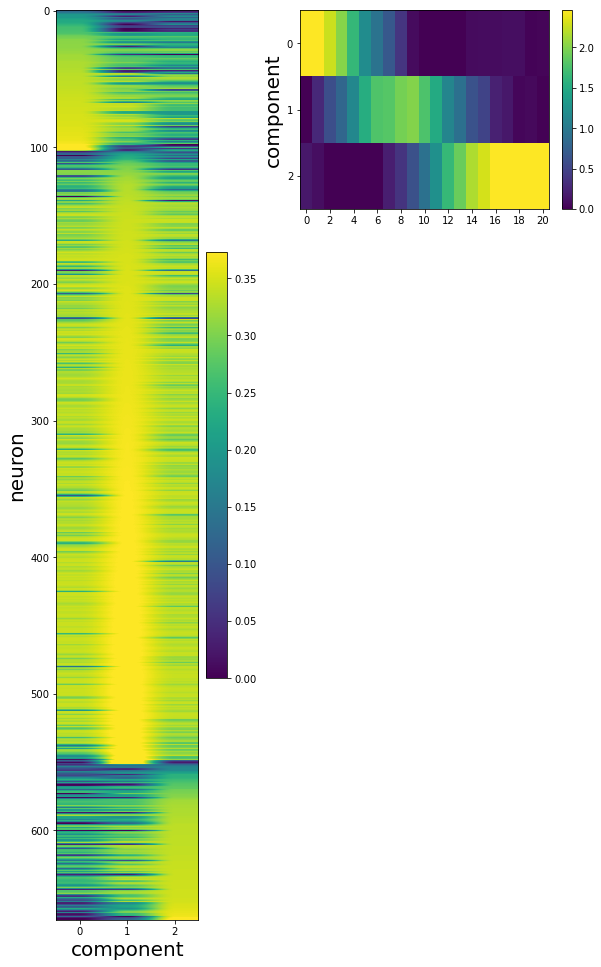

In [344]:
import nmf_analysis as na
X = mus_population
X = X.at[X < 0].set(0.)
X_normed,neuron_field_mask,non_na_original_ind = na.normalize(X)
k = 3
W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted = na.nmf_and_sort(X_normed, k, model=None)

import nmf_plot as nmfp
nmfp.plot_wh(W_sorted,H_sorted)
